# AA Tau Data: Spectra Reduction

Quick Links

* Data Reduction
    - Optical
        - [Optical 2014](#opt14)
           - [Dec 12](#opt14_12)
           - [Dec 02](#opt14_02)
        - [Optical 2008](#opt08)
    - [Infrared](#ir)
* [Combine opt and ir](#scaling)
    - [Spectrophotometry](#photometry)
        - [AAVSO photometry](#AAVSO)
        - [Bouvier/Schneider photometry](#googledocs)

[Write data to files](#write)



In [1]:
import numpy as np
import tarfile

In [2]:
import matplotlib.pyplot as plt
# %matplotlib notebook  
%matplotlib inline 

In [3]:
from astropy.io import fits

In [4]:
import scipy.interpolate as interp
from sys import platform

In [5]:
from astropy import units as u

In [6]:
from astropy.table import QTable
from astropy.io import ascii

In [7]:
from synphot import units
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D,Empirical1D

# Optical 2014 <a name="opt14"></a>


> From: Gregory Herczeg <gherczeg1@gmail.com>  
Date: Mon, Sep 21, 2015 at 6:38 PM  
Subject: AA Tau spectra  
To: Kevin Covey <kevin.covey@wwu.edu>  

> ...Most of this data was obtained at UH88, the spectra are from the automated reduction.  I've developed an alternative pipeline for the red, but not the blue, and without fluxcal.  So, for now, this is what we have.  We also have V-band from acquisition images, so it should be possible to test the fluxcal that way.

> The one ascii file is from DBSP in 2008 and should be good, with accurate fluxcal.

> ftp://ftp.mpe.mpg.de/people/gregoryh/forkc


From Kevin:

> While documenting everything for an 'observations' section, I was able to figure out the timing of the optical spectra that were observed in 2014.  It looks like spec_C14_346_066_001_17_R.fits and spec_C14_346_199_001_17_R.fits (and B.fits) are the closest optical spectra to our Dec. 12 NIR observations, and spec_C14_336_061_001_17_R.fits and spec_C14_336_162_001_17_R.fits (and B.fits, of course) are closest to our Dec. 2nd NIR spectra. 

Dec 12, 2014

spec_C14_346_066_001_17_R.fits and B.fits (later found to be bad in B, see below) 

spec_C14_346_199_001_17_R.fits and B.fits


Dec 2, 2014

spec_C14_336_061_001_17_R.fits and B.fits

spec_C14_336_162_001_17_R.fits and B.fits


In [8]:
# aatautar = tarfile.open('../../DATA/AATau.tar.gz')
# aatautar.list()
# aatautar.extractall(path="../../DATA/")
# aatautar.close()

## Dec 12, 2014 <a name="opt14_12"></a>

**R band first:**

In [9]:
hdulist = fits.open('../..//DATA/AATau/Optical/spec_C14_346_066_001_17_R.fits')
# hdulist.info()
Rdata=hdulist[0].data
Rstart=hdulist[0].header['CRVAL1']
Rstep=hdulist[0].header['CDELT1']
Rwavelength_346_066=np.arange(Rstart,Rstart+Rstep*Rdata.size,Rstep)*1.0E-4 # microns
Rdata_346_066=hdulist[0].data
hdulist.close()

In [10]:
hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_346_199_001_17_R.fits')
# hdulist.info()
Rdata=hdulist[0].data
Rstart=hdulist[0].header['CRVAL1']
Rstep=hdulist[0].header['CDELT1']
Rwavelength_346_199=np.arange(Rstart,Rstart+Rstep*Rdata.size,Rstep)*1.0E-4 # MICRONS MICRONS MICRONS!
Rdata_346_199=hdulist[0].data
hdulist.close()

In [11]:
hdulist[0].header['FLXUNITS']

'erg/s/cm2/A'

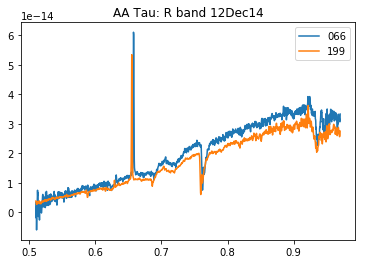

In [12]:
fig,ax=plt.subplots()
ax.plot(Rwavelength_346_066,Rdata_346_066,label="066")
ax.plot(Rwavelength_346_199,Rdata_346_199,label="199")
ax.set_title("AA Tau: R band 12Dec14")
ax.legend(loc="best")
plt.show()

In [13]:
np.min(Rwavelength_346_199),np.min(Rwavelength_346_066)  # They match

(0.510113, 0.510113)

Step 1 = Shift horizontally by matching Halpha peaks, scale vertically by matching the average flux in the flats from 0.78 to 0.92 microns

In [14]:
shift=np.argmax(Rdata_346_066)-np.argmax(Rdata_346_199)
shift

9

In [15]:
Rwavelength_346_066[9]-Rwavelength_346_066[0]

0.0026370000000002225

In [16]:
scale = np.average(Rdata_346_066[np.logical_and(Rwavelength_346_066 < 0.92, 
                                                Rwavelength_346_066 > 0.78)]) \
    / np.average(Rdata_346_199[np.logical_and(Rwavelength_346_199 < 0.92, 
                                              Rwavelength_346_199 > 0.78)]) 
scale    

1.1559718

The problem might be that the wavelengths aren't true without the horizontal shift, but we'll ignore that for now.

Use the 199 wavelengths: chop off the end and shift+scale the 066 onto it

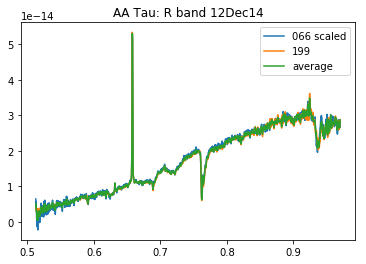

In [17]:
fig,ax=plt.subplots()
ax.plot(Rwavelength_346_066[shift:], Rdata_346_066[shift:]/scale,label="066 scaled")
ax.plot(Rwavelength_346_066[shift:], Rdata_346_199[:-shift],label="199")

Rdata_dec12=(Rdata_346_199[:-shift]+Rdata_346_066[shift:]/scale)/2.0
Rwavelength_dec12=Rwavelength_346_066[shift:]
ax.plot(Rwavelength_dec12,Rdata_dec12,label="average")
ax.set_title("AA Tau: R band 12Dec14")
ax.legend(loc="best")
plt.show()

**Next B:**

In [18]:
hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_346_066_001_17_B.fits')
# hdulist.info()
Bdata=hdulist[0].data
Bstart=hdulist[0].header['CRVAL1']
Bstep=hdulist[0].header['CDELT1']
Bwavelength_346_066=np.arange(Bstart,Bstart+Bstep*Bdata.size,Bstep)*1.0E-4 # microns
Bdata_346_066=hdulist[0].data
hdulist.close()

hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_346_199_001_17_B.fits')
# hdulist.info()
Bdata=hdulist[0].data
Bstart=hdulist[0].header['CRVAL1']
Bstep=hdulist[0].header['CDELT1']
Bwavelength_346_199=np.arange(Bstart,Bstart+Bstep*Bdata.size,Bstep)*1.0E-4 # microns
Bdata_346_199=hdulist[0].data
hdulist.close()

Yikes!  346_066 is way too messy in B:

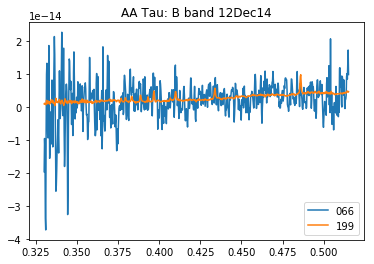

In [19]:
fig,ax=plt.subplots()
ax.plot(Bwavelength_346_066,Bdata_346_066,label="066")
ax.plot(Bwavelength_346_199,Bdata_346_199,label="199")
ax.set_title("AA Tau: B band 12Dec14")
ax.legend(loc="best")
plt.show()

Use only the 199 data (no shift, no scale):

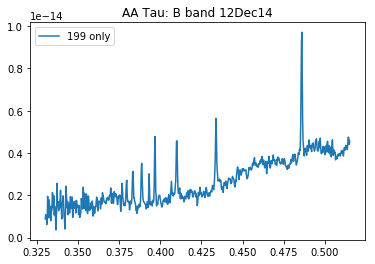

In [20]:
fig,ax=plt.subplots()
Bdata_dec12=Bdata_346_199
Bwavelength_dec12=Bwavelength_346_199
ax.plot(Bwavelength_dec12,Bdata_dec12,label="199 only")
ax.set_title("AA Tau: B band 12Dec14")
ax.legend(loc="best")
plt.show()

**Match R and B?  Bottom line is that they don't overlap that much**

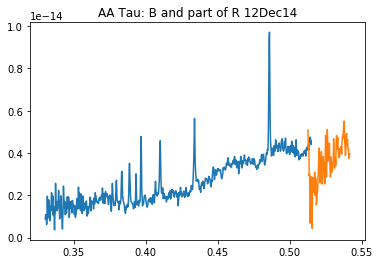

In [21]:
fig,ax=plt.subplots()
ax.plot(Bwavelength_dec12,Bdata_dec12)
ax.plot(Rwavelength_dec12[:100],Rdata_dec12[:100])
ax.set_title("AA Tau: B and part of R 12Dec14")
plt.show()

In [22]:
Bwavelength_dec12[-20:],Rwavelength_dec12[:20]

(array([0.51051 , 0.510748, 0.510986, 0.511224, 0.511462, 0.5117  ,
        0.511938, 0.512176, 0.512414, 0.512652, 0.51289 , 0.513128,
        0.513366, 0.513604, 0.513842, 0.51408 , 0.514318, 0.514556,
        0.514794, 0.515032]),
 array([0.51275 , 0.513043, 0.513336, 0.513629, 0.513922, 0.514215,
        0.514508, 0.514801, 0.515094, 0.515387, 0.51568 , 0.515973,
        0.516266, 0.516559, 0.516852, 0.517145, 0.517438, 0.517731,
        0.518024, 0.518317]))

Conclusion: lop off points 0-7 of R band to "match"

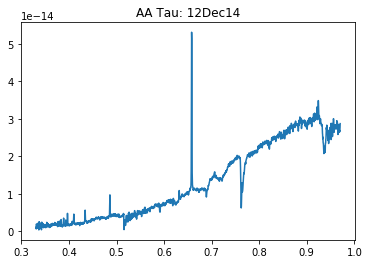

In [23]:
wavelength_dec12=np.append(Bwavelength_dec12,Rwavelength_dec12[8:])
data_dec12=np.append(Bdata_dec12,Rdata_dec12[8:])
fig,ax=plt.subplots()
ax.plot(wavelength_dec12,data_dec12)
ax.set_title("AA Tau: 12Dec14")
plt.show()

## Dec 2, 2014 <a name="opt14_02"></a>

**R and B, just as above:**

In [24]:
hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_336_061_001_17_R.fits')
# hdulist.info()
Rdata=hdulist[0].data
Rstart=hdulist[0].header['CRVAL1']
Rstep=hdulist[0].header['CDELT1']
Rwavelength_336_061=np.arange(Rstart,Rstart+Rstep*Rdata.size,Rstep)*1.0E-4 # microns
Rdata_336_061=hdulist[0].data
hdulist.close()

hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_336_162_001_17_R.fits')
# hdulist.info()
Rdata=hdulist[0].data
Rstart=hdulist[0].header['CRVAL1']
Rstep=hdulist[0].header['CDELT1']
Rwavelength_336_162=np.arange(Rstart,Rstart+Rstep*Rdata.size,Rstep)*1.0E-4 # microns
Rdata_336_162=hdulist[0].data
hdulist.close()

shift=np.argmax(Rdata_336_061)-np.argmax(Rdata_336_162)

scale = np.average(Rdata_336_061[np.logical_and(Rwavelength_336_061 < 0.92, 
                                                Rwavelength_336_061 > 0.78)]) \
    / np.average(Rdata_336_162[np.logical_and(Rwavelength_336_162 < 0.92, 
                                              Rwavelength_336_162 > 0.78)]) 
shift,scale

(4, 1.0501788)

In [25]:
hdulist[0].header['FLXUNITS']

'erg/s/cm2/A'

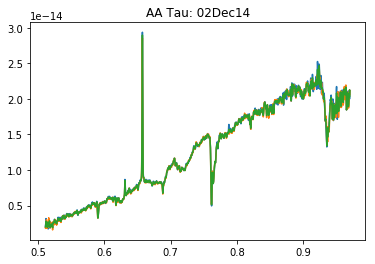

In [26]:
fig,ax=plt.subplots()
ax.plot(Rwavelength_336_061[shift:],Rdata_336_061[shift:])
ax.plot(Rwavelength_336_162[shift:],scale * Rdata_336_162[:-shift])

Rdata_dec02=(scale*Rdata_336_162[:-shift]+Rdata_336_061[shift:])/2.0
Rwavelength_dec02=Rwavelength_336_061[shift:]
ax.plot(Rwavelength_dec02,Rdata_dec02)
ax.set_title("AA Tau: 02Dec14")

plt.show()

In [27]:
hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_336_061_001_17_B.fits')
# hdulist.info()
Bdata=hdulist[0].data
Bstart=hdulist[0].header['CRVAL1']
Bstep=hdulist[0].header['CDELT1']
Bwavelength_336_061=np.arange(Bstart,Bstart+Bstep*Bdata.size,Bstep)*1.0E-4 # microns
Bdata_336_061=hdulist[0].data
hdulist.close()

hdulist = fits.open('../../DATA/AATau/Optical/spec_C14_336_162_001_17_B.fits')
# hdulist.info()
Bdata=hdulist[0].data
Bstart=hdulist[0].header['CRVAL1']
Bstep=hdulist[0].header['CDELT1']
Bwavelength_336_162=np.arange(Bstart,Bstart+Bstep*Bdata.size,Bstep)*1.0E-4 # microns
Bdata_336_162=hdulist[0].data
hdulist.close()

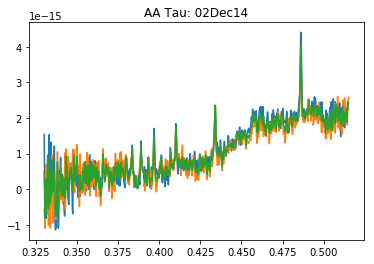

In [28]:
fig,ax=plt.subplots()
ax.plot(Bwavelength_336_061,Bdata_336_061)
ax.plot(Bwavelength_336_162,Bdata_336_162)

# These look good, so just average:

Bdata_dec02=(Bdata_336_162+Bdata_336_061)/2.0
Bwavelength_dec02=Bwavelength_336_061
ax.plot(Bwavelength_dec02,Bdata_dec02)
ax.set_title("AA Tau: 02Dec14")
plt.show()

**Do R and B match?  Better than Dec 12!**

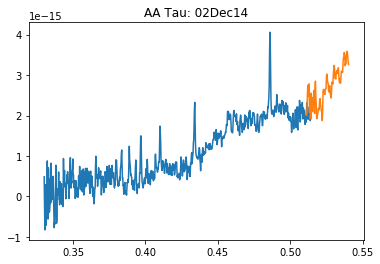

In [29]:
fig,ax=plt.subplots()
ax.plot(Bwavelength_dec02,Bdata_dec02)
ax.plot(Rwavelength_dec02[:100],Rdata_dec02[:100])
ax.set_title("AA Tau: 02Dec14")
plt.show()

In [30]:
Bwavelength_dec02[-20:],Rwavelength_dec02[:20]

(array([0.51051 , 0.510748, 0.510986, 0.511224, 0.511462, 0.5117  ,
        0.511938, 0.512176, 0.512414, 0.512652, 0.51289 , 0.513128,
        0.513366, 0.513604, 0.513842, 0.51408 , 0.514318, 0.514556,
        0.514794, 0.515032]),
 array([0.511285, 0.511578, 0.511871, 0.512164, 0.512457, 0.51275 ,
        0.513043, 0.513336, 0.513629, 0.513922, 0.514215, 0.514508,
        0.514801, 0.515094, 0.515387, 0.51568 , 0.515973, 0.516266,
        0.516559, 0.516852]))

Conclusion: To match, lop points 0-12 off of R to "match"

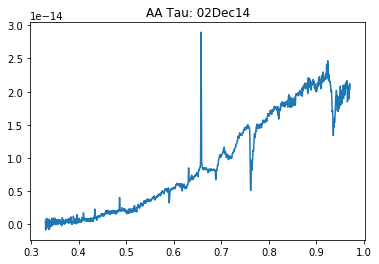

In [31]:
wavelength_dec02=np.append(Bwavelength_dec02,Rwavelength_dec02[13:])
data_dec02=np.append(Bdata_dec02,Rdata_dec02[13:])

fig,ax=plt.subplots()
ax.plot(wavelength_dec02,data_dec02)
ax.set_title("AA Tau: 02Dec14")
plt.show()

# Optical 2008 <a name="opt08"></a>

In [32]:
wavelength2, data2, junk1, junk2 = np.loadtxt('../../DATA/AATau/Optical/aatau.dat', unpack=True,skiprows=9)
wavelength2=wavelength2/10000.0
wavelength3, data3, junk3, junk4 = np.loadtxt('../../DATA/AATau/Optical/aataublue.dat', unpack=True,skiprows=9)
wavelength3=wavelength3/10000.0
wavelength_2008=np.append(wavelength3[::-1],wavelength2)
data_2008=np.append(data3[::-1],data2)

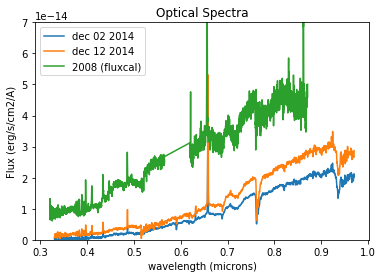

In [33]:
fig,ax=plt.subplots()
ax.plot(wavelength_dec02,data_dec02,label='dec 02 2014')
ax.plot(wavelength_dec12,data_dec12,label='dec 12 2014')
ax.plot(wavelength_2008,data_2008,label='2008 (fluxcal)')
ax.legend(loc='best')
ax.set_ylim(0,0.7E-13)
ax.set_xlabel("wavelength (microns)")
ax.set_ylabel("Flux (erg/s/cm2/A)")
ax.set_title("Optical Spectra")
plt.show()

Wavelength looks good, features in the same place.

# Infrared <a name="ir"></a>

-- 2014 --  
Dec 2:

merge.AA_Tau.3-10.fits  
merge.AA_Tau.28-31.fits  
merge.AA_Tau.84-87.fits  

Dec 12:

comb.AA_Tau.31-34.fits  
comb.AA_Tau.59-62.fits  
comb.AA_Tau.111-114.fits  

-- 2008 --  
final.AATau.31-34.fits

Kevin rewrote the files as AA_Tau.Dec2_2014.3-10.txt, etc:

In [34]:
IRwav2a, IRdata2a, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec2_2014.3-10.txt', unpack=True)
IRwav2b, IRdata2b, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec2_2014.28-31.txt', unpack=True)
IRwav2c, IRdata2c, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec2_2014.84-87.txt', unpack=True)
IRwav12a, IRdata12a, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec12_2014.31-34.txt', unpack=True)
IRwav12b, IRdata12b, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec12_2014.59-62.txt', unpack=True)
IRwav12c, IRdata12c, junk= np.loadtxt('../../DATA/AATau/IR/AA_Tau.Dec12_2014.111-114.txt', unpack=True)


hdulist = fits.open('../../DATA/AATau/IR/final.AATau.31-34.fits')
IRwavelength_2008=hdulist[0].data[0]
IRdata_2008=hdulist[0].data[1]
hdulist.close()

All IR wavelengths have a hitch around element 5000??

2a and 2c are 7099 elements, 2b is 7100 elements

12a is 7063, 12b is 7080, 12c is 7088

Bottom line is that they are all different!  

In [35]:
# mask out the NaNs:
def maskNans(wavelength,data):
    
    masked_data=data[np.logical_not(np.isnan(data))]
    masked_wavelength=wavelength[np.logical_not(np.isnan(data))]

    return (masked_wavelength,masked_data)

IRwav2a, IRdata2a = maskNans(IRwav2a, IRdata2a)
IRwav2b, IRdata2b = maskNans(IRwav2b, IRdata2b)
IRwav2c, IRdata2c = maskNans(IRwav2c, IRdata2c)
IRwav12a, IRdata12a = maskNans(IRwav12a, IRdata12a)
IRwav12b, IRdata12b = maskNans(IRwav12b, IRdata12b)
IRwav12c, IRdata12c = maskNans(IRwav12c, IRdata12c)

IRwavelength_2008, IRdata_2008 = maskNans(IRwavelength_2008, IRdata_2008)

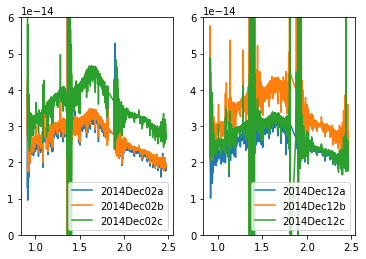

In [36]:
fig,[ax1,ax2]=plt.subplots(1,2)
ax1.plot(IRwav2a,IRdata2a,label='2014Dec02a')
ax1.plot(IRwav2b,IRdata2b,label='2014Dec02b')
ax1.plot(IRwav2c,IRdata2c,label='2014Dec02c')
ax2.plot(IRwav12a,IRdata12a,label='2014Dec12a')
ax2.plot(IRwav12b,IRdata12b,label='2014Dec12b')
ax2.plot(IRwav12c,IRdata12c,label='2014Dec12c')
ax1.legend(loc='best')
ax1.set_ylim(0,0.6e-13)
ax2.legend(loc='best')
ax2.set_ylim(0,0.6e-13)
plt.show()

Wavelength calibration looks good.  The third on Dec 2 and the second on Dec 12 do not look like the other two.  Why?

# Scaling IR and Optical <a name="scaling"></a>

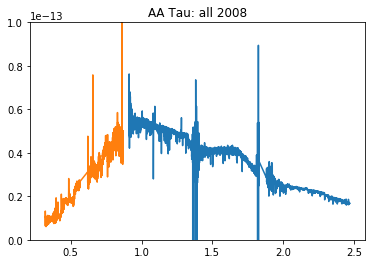

In [37]:
fig,ax=plt.subplots()
ax.plot(IRwavelength_2008,IRdata_2008)
ax.plot(wavelength_2008,data_2008)
ax.set_ylim(0,1E-13)
ax.set_title("AA Tau: all 2008")
plt.show()

The 2008 infrared matches reasonably with the 2008 optical, which is flux calibrated.  Therefore, don't do any scaling on the 2008.

There are three scaling tasks for the 2014 data: 
* scale the three infrared to match each other
* scale the infrared to the optical
* scale the overall 2014 spectrum by some unknown amount.  

Getting the opt-ir to fit for the 2014 is easy because they overlap:

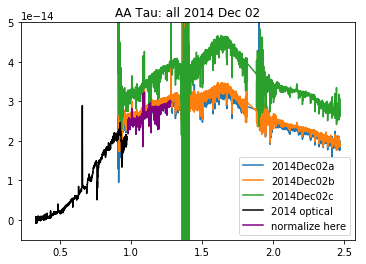

In [38]:
fig,ax=plt.subplots()
ax.plot(IRwav2a,IRdata2a,label='2014Dec02a')
ax.plot(IRwav2b,IRdata2b,label='2014Dec02b')
ax.plot(IRwav2c,IRdata2c,label='2014Dec02c')
ax.plot(wavelength_dec02,data_dec02,'k',label='2014 optical')
ax.plot(IRwav2a[500:2400],IRdata2a[500:2400],'purple',label='normalize here')
ax.legend(loc='best')
ax.set_title("AA Tau: all 2014 Dec 02")
ax.set_ylim(-0.05E-13,0.5E-13)
plt.show()

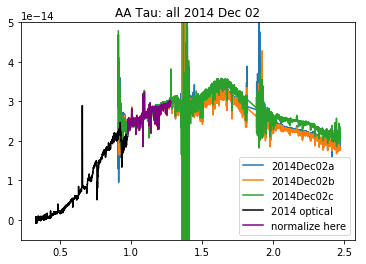

In [39]:
IRdata2b_scale=IRdata2b*np.mean(IRdata2a[500:2400])/np.mean(IRdata2b[500:2400])
IRdata2c_scale=IRdata2c*np.mean(IRdata2a[500:2400])/np.mean(IRdata2c[500:2400])

fig,ax=plt.subplots()
ax.plot(IRwav2a,IRdata2a,label='2014Dec02a')
ax.plot(IRwav2b,IRdata2b_scale,label='2014Dec02b')
ax.plot(IRwav2c,IRdata2c_scale,label='2014Dec02c')
ax.plot(wavelength_dec02,data_dec02,'k',label='2014 optical')
ax.plot(IRwav2a[500:2400],IRdata2a[500:2400],'purple',label='normalize here')
ax.legend(loc='best')
ax.set_title("AA Tau: all 2014 Dec 02")
ax.set_ylim(-0.05E-13,0.5E-13)
plt.show()

Conclusion:  The third spectrum does not seem to go, because a simple scaling won't bring the long wavelength in line.  Keep the first two, scale to fit in the purple region, then average.

In [40]:
np.mean(IRdata2b[500:2400])/np.mean(IRdata2a[500:2400])

1.0521492864173225

In [41]:
IRwav2a[500],IRwav2a[2400],IRwav2b[500],IRwav2b[2400],IRwav2c[500],IRwav2c[2400]

(0.978254, 1.27883, 0.978108, 1.27865, 0.978254, 1.27883)

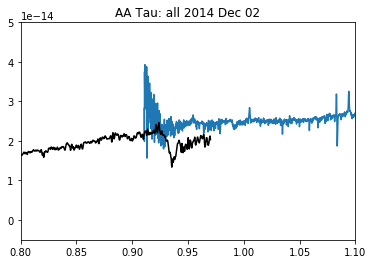

In [42]:
f_IRdat2b=interp.interp1d(IRwav2b,IRdata2b_scale)

IRwavelength_dec02=IRwav2a[:-5]
IRdata_dec02=(IRdata2a[:-5]+f_IRdat2b(IRwavelength_dec02))/2.0

fig,ax=plt.subplots()
ax.plot(IRwavelength_dec02,IRdata_dec02,label='2014Dec02')
ax.plot(wavelength_dec02,data_dec02,'k',label='2014 optical')
ax.set_ylim(-0.05E-13,0.5E-13)
ax.set_xlim(0.8,1.1)
ax.set_title("AA Tau: all 2014 Dec 02")
plt.show()

Not sure about the hitch in the long end of the optical... Match
the slope in 0.85 to 0.90 microns projected to the value at 0.945?  Yes, this works.

In [43]:
fitrange=np.logical_and(wavelength_dec02>0.85,wavelength_dec02<0.90)
m,b=np.polyfit(wavelength_dec02[fitrange],data_dec02[fitrange],1)
m*0.945+b

2.4121483272671015e-14

In [44]:
IRrange=np.logical_and(IRwavelength_dec02>0.94,IRwavelength_dec02<0.95)
np.average(IRdata_dec02[IRrange])

2.3951466319904803e-14

In [45]:
(m*0.945+b)/(np.average(IRdata_dec02[IRrange]))

1.0070983943319127

So, ~~multiply the IR~~ divide the optical by 1.0071

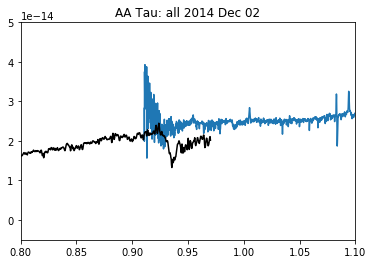

In [46]:
IRwavelength_dec02=IRwav2a[:-5]
IRdata_dec02=(IRdata2a[:-5]+f_IRdat2b(IRwavelength_dec02))/2.0
data_dec02scale=data_dec02/1.0071

fig,ax=plt.subplots()
ax.plot(IRwavelength_dec02,IRdata_dec02,label='2014Dec02')
ax.plot(wavelength_dec02,data_dec02scale,'k',label='2014 optical')
ax.set_ylim(-0.05E-13,0.5E-13)
ax.set_xlim(0.8,1.1)
ax.set_title("AA Tau: all 2014 Dec 02")
plt.show()

**Repeat for the other night**

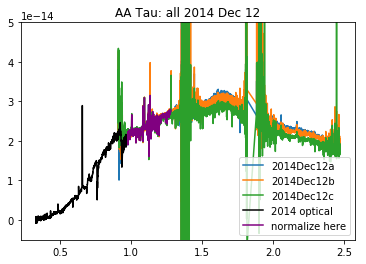

In [47]:
IRdata12b_scale=IRdata12b*np.mean(IRdata12a[500:2400])/np.mean(IRdata12b[500:2400])
IRdata12c_scale=IRdata12c*np.mean(IRdata12a[500:2400])/np.mean(IRdata12c[500:2400])

fig,ax=plt.subplots()
ax.plot(IRwav12a,IRdata12a,label='2014Dec12a')
ax.plot(IRwav12b,IRdata12b_scale,label='2014Dec12b')
ax.plot(IRwav12c,IRdata12c_scale,label='2014Dec12c')
ax.plot(wavelength_dec02,data_dec02,'k',label='2014 optical')
ax.plot(IRwav12a[500:2400],IRdata12a[500:2400],'purple',label='normalize here')
ax.legend(loc='best')
ax.set_ylim(-0.05E-13,0.5E-13)
ax.set_title("AA Tau: all 2014 Dec 12")
plt.show()

These look better.

In [48]:
np.mean(IRdata12a[500:2400])/np.mean(IRdata12b[500:2400]),np.mean(IRdata12a[500:2400])/np.mean(IRdata12c[500:2400])

(0.7405687103075506, 0.8886580796476184)

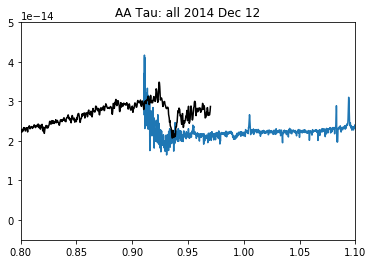

In [49]:
f_IRdat12b=interp.interp1d(IRwav12b,IRdata12b_scale)
f_IRdat12c=interp.interp1d(IRwav12c,IRdata12c_scale)

IRwavelength_dec12=IRwav12a
IRdata_dec12=(IRdata12a+f_IRdat12b(IRwavelength_dec12)+f_IRdat12b(IRwavelength_dec12))/3.0

fig,ax=plt.subplots()
ax.plot(IRwavelength_dec12,IRdata_dec12,label='2014Dec12')
ax.plot(wavelength_dec12,data_dec12,'k',label='2014 optical')
ax.set_ylim(-0.05E-13,0.5E-13)
ax.set_xlim(0.8,1.1)
ax.set_title("AA Tau: all 2014 Dec 12")
plt.show()

In [50]:
fitrange=np.logical_and(wavelength_dec12>0.85,wavelength_dec12<0.90)
m,b=np.polyfit(wavelength_dec12[fitrange],data_dec12[fitrange],1)
m*0.945+b

3.244692956435506e-14

In [51]:
IRrange=np.logical_and(IRwavelength_dec12>0.94,IRwavelength_dec12<0.95)
np.average(IRdata_dec12[IRrange])
# IRdata_dec12[IRrange]

2.132672425384208e-14

In [52]:
(m*0.945+b)/(np.average(IRdata_dec12[IRrange]))

1.5214211605192784

So, ~~multiply the IR~~ divide the optical by 1.5214 (multiply by 0.657) to match. 

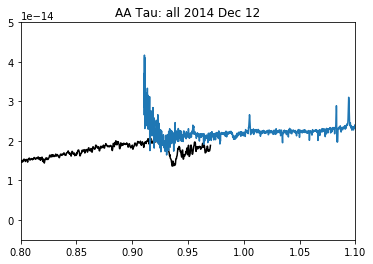

In [53]:
f_IRdat12b=interp.interp1d(IRwav12b,IRdata12b_scale)
f_IRdat12c=interp.interp1d(IRwav12c,IRdata12c_scale)

IRwavelength_dec12=IRwav12a
IRdata_dec12=(IRdata12a+f_IRdat12b(IRwavelength_dec12)+f_IRdat12b(IRwavelength_dec12))/3.0
data_dec12scale=data_dec12/1.5214

fig,ax=plt.subplots()
ax.plot(wavelength_dec12,data_dec12scale,'k',label='2014 optical')
ax.plot(IRwavelength_dec12,IRdata_dec12,label='2014Dec12')
ax.set_ylim(-0.05E-13,0.5E-13)
ax.set_xlim(0.8,1.1)
ax.set_title("AA Tau: all 2014 Dec 12")
plt.show()

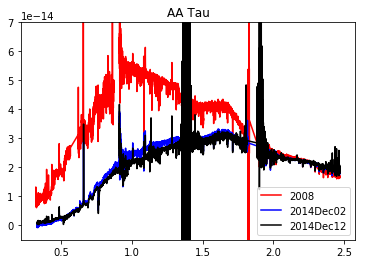

In [54]:
fig,ax=plt.subplots()
ax.plot(IRwavelength_2008,IRdata_2008,'r')
ax.plot(wavelength_2008,data_2008,'r',label='2008')
ax.plot(IRwavelength_dec02,IRdata_dec02,'b',label='2014Dec02')
ax.plot(wavelength_dec02,data_dec02scale,'b')
ax.plot(IRwavelength_dec12,IRdata_dec12,'k',label='2014Dec12')
ax.plot(wavelength_dec12,data_dec12scale,'k')
ax.legend(loc='best')
ax.set_title('AA Tau')
ax.set_ylim(-0.05E-13,0.7E-13)
plt.show()

To recap, there are three scaling tasks for the 2014 data: 
* ~~scale the three infrared to match each other~~
* ~~scale the infrared to the optical~~
* scale the overall 2014 spectrum by some unknown amount.  


**To scale, we need photometry.  To do photometry, we need units.**

**Units:  1 erg/s = 1E-7 W, so 1 erg/s cm^2 = 1E-3 W/ m^2 and 1 erg/s cm^2 A = 10 W/ m^2 um**

# Use photometry to constrain the scaling: <a name="photometry"></a>

Ready data for synthetic photometry with units:

In [55]:
IRdata_dec02u = IRdata_dec02    * u.erg / (u.s * u.cm * u.cm * u.AA)
IRdata_dec12u = IRdata_dec12    * u.erg / (u.s * u.cm * u.cm * u.AA)
IRdata_2008u  = IRdata_2008     * u.erg / (u.s * u.cm * u.cm * u.AA)
data_dec02u   = data_dec02scale * u.erg / (u.s * u.cm * u.cm * u.AA)
data_dec12u   = data_dec12scale * u.erg / (u.s * u.cm * u.cm * u.AA)
data_2008u    = data_2008       * u.erg / (u.s * u.cm * u.cm * u.AA)

In [56]:
IRwavelength_dec02u = IRwavelength_dec02 * u.micron
IRwavelength_dec12u = IRwavelength_dec12 * u.micron
IRwavelength_2008u  =  IRwavelength_2008 * u.micron
wavelength_dec02u   =   wavelength_dec02 * u.micron
wavelength_dec12u   =   wavelength_dec12 * u.micron
wavelength_2008u    =    wavelength_2008 * u.micron

Load necessary files for synthetic photometry:

In [57]:
# Optional, for when the STScI ftp server is not answering:
from synphot import config
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

vega = SourceSpectrum.from_vega()
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')


Little function for getting magnitudes:

In [58]:
def getMag(band,wavelengths,fluxes):  # where band = v_band, etc
    sp = SourceSpectrum(Empirical1D, points=wavelengths, lookup_table=fluxes)
    sp_obs = Observation(sp, band)
    return sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value # default binned=False

WARNING!  I have suppressed warning from here on out because synphot complains mightily about the few negative flux values.

In [59]:
import warnings
warnings.filterwarnings('ignore')

## AAVSO photometry <a name="AAVSO"></a>

Options:

A. Tie the whole scale to the AAVSO data:  V(2014) = 15.0

B. Use magnitudes from the literature:

> <em>X-ray to NIR emission from AA Tauri during the dim state - Occultation of the inner disk and gas-to-dust ratio of the absorber</em>

> P. C. Schneider, K. France, H. M. Günther, G. J. Herczeg, J. Robrade, J. Bouvier, M. McJunkin, J. H. M. M. Schmitt

> (Submitted on 16 Sep 2015)

These new observations happen just at the end of their plot, so 15.2 ish.  


C. **From Kevin: V = 12.73$\pm$0.35 in 2008 to V = 14.95$\pm$0.43 in 2014** (dated 2/22/18 from figure)

**So, accept all scaling that will yield between V = 14.52 and V = 15.38 in 2014.**

No scaling:

In [60]:
getMag(v_band,wavelength_2008u,data_2008u)

12.849020523504532

In [61]:
getMag(v_band,wavelength_dec02u,data_dec02u)

14.848164355910296

In [62]:
getMag(v_band,wavelength_dec12u,data_dec12u)

14.94780732718885

Hunt and peck scaling values to find what would be within the V=14.52 and V=15.38 AAVSO range: 

In [63]:
getMag(v_band,wavelength_dec02u,data_dec02u*0.60)

15.402786185746988

In [64]:
getMag(v_band,wavelength_dec02u,data_dec02u*1.40)

14.482844282428271

In [65]:
getMag(v_band,wavelength_dec12u,data_dec12u*0.70)

15.335062244915306

In [66]:
getMag(v_band,wavelength_dec12u,data_dec12u*1.40)

14.582487255755353

**Conclusion: Scale Dec02 by 0.6 -> 1.4 and Dec12 by 0.7 -> 1.4 based on AAVSO V.**

## Scaling, Revisited <a name="googledocs"></a>

Now use the Bouvier/Schneider photometry on google docs.  Consider everything at the fall 2011 campaign and more recent.

limit | V | R | J | H | K
--- | --- | --- | --- | --- | ---
min | 13.50 | 12.04 | 10.46 | 9.20 | 8.43
max | 16.49 | 14.83  | 11.13 | 10.13 | 9.70

Find which scaling values for the dec02 data would yield the Bouvier/Schneider magnitues:

In [67]:
test=np.array([])

for j in np.arange(0.2,2.0,.01):
    if 9.70 > getMag(k_band,IRwavelength_dec02u,IRdata_dec02u*j) > 8.43:
        test=np.append(test,j)
        
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.24000000000000005, ' max=', 0.7500000000000004)

In [68]:
for j in np.arange(0.2,2.0,.01):
    if 10.13 > getMag(h_band,IRwavelength_dec02u,IRdata_dec02u*j) > 9.2:
        test=np.append(test,j)
        
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.24000000000000005, ' max=', 0.7500000000000004)

In [69]:
for j in np.arange(0.2,2.0,.01):
    if 11.13 > getMag(j_band,IRwavelength_dec02u,IRdata_dec02u*j) > 10.46:
        test=np.append(test,j)
  
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.24000000000000005, ' max=', 0.7500000000000004)

These NIR magnitudes are very faint, and the optical magnitudes are over too large a range.  Look what scaling like this does to the optical mags:

In [70]:
getMag(v_band,wavelength_dec02u,data_dec02u*0.24),getMag(v_band,wavelength_dec02u,data_dec02u*0.75)

(16.397636277000206, 15.160511196755554)

So, the V = 15.2 is just barely consistent with Kevin's read of the AAVSO data.  

My read of the AAVSO data is that V could be anywhere between 14.3 and 15.8:

In [71]:
test=np.array([])
for j in np.arange(0.2,2.0,.01):
    if 15.8 > getMag(v_band,wavelength_dec02u,data_dec02u*j) > 14.3:
        test=np.append(test,j)
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.4200000000000002, ' max=', 1.6500000000000012)

The V=13.5 and V=19.5 from the google docs is just too big a range to be useful.

Repeat for the other night:

In [72]:
test=np.array([])
for j in np.arange(0.2,2.0,.01):
    if 9.7 > getMag(k_band,IRwavelength_dec12u,IRdata_dec12u*j) > 8.43:
        test=np.append(test,j)
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.24000000000000005, ' max=', 0.7400000000000004)

In [73]:
test=np.array([])
for j in np.arange(0.2,2.0,.01):
    if 15.8 > getMag(v_band,wavelength_dec12u,data_dec12u*j) > 14.3:
        test=np.append(test,j)
print,'min=',np.min(test),' max=',np.max(test)

(<function print>, 'min=', 0.46000000000000024, ' max=', 1.8100000000000014)

**Conclusion: do no apply scaling other than unity.**

# Write data to files <a name="write"></a>

In [74]:
t = QTable([IRwavelength_2008u.astype('float32'), IRdata_2008u.astype('float32')], names=['wavelength', 'flux'])
ascii.write(t, format='ecsv', output='AATau_IR2008.txt', overwrite=True)   

t = QTable([wavelength_2008u.astype('float32'), data_2008u.astype('float32')], names=['wavelength', 'flux'])
ascii.write(t, format='ecsv', output='AATau_opt2008.txt', overwrite=True)   

t = QTable([IRwavelength_dec02u.astype('float32'), IRdata_dec02u.astype('float32')], names=['wavelength', 'flux'])
ascii.write(t, format='ecsv', output='AATau_IR2014dec02.txt', overwrite=True)   

t = QTable([wavelength_dec02u.astype('float32'), data_dec02u.astype('float32')], names=['wavelength', 'flux'])
ascii.write(t, format='ecsv', output='AATau_opt2014dec02.txt', overwrite=True)   

t = QTable([IRwavelength_dec12u.astype('float32'), IRdata_dec12u.astype('float32')], names=['wavelength', 'flux'])
ascii.write(t, format='ecsv', output='AATau_IR2014dec12.txt', overwrite=True)   

t = QTable([wavelength_dec12u.astype('float32'), data_dec12u.astype('float32')], names=['wavelength', 'flux'])
# t['wavelength'] = t['wavelength'].astype('float32')
ascii.write(t, format='ecsv', output='AATau_opt2014dec12.txt', overwrite=True)   
